In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
from PIL import Image
from IPython.display import Image as imshow
from scipy.ndimage.filters import gaussian_filter

In [2]:
# downloading files for inception network
!wget https://raw.githubusercontent.com/ElephantHunters/Deep-Dream-using-Tensorflow/master/download.py
!wget https://raw.githubusercontent.com/ElephantHunters/Deep-Dream-using-Tensorflow/master/inception5h.py

--2019-02-16 12:26:13--  https://raw.githubusercontent.com/ElephantHunters/Deep-Dream-using-Tensorflow/master/download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3161 (3.1K) [text/plain]
Saving to: ‘download.py’

download.py         100%[===================>]   3.09K  --.-KB/s    in 0s      

2019-02-16 12:26:18 (73.3 MB/s) - ‘download.py’ saved [3161/3161]

--2019-02-16 12:26:20--  https://raw.githubusercontent.com/ElephantHunters/Deep-Dream-using-Tensorflow/master/inception5h.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371

In [3]:
import inception5h
inception5h.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [4]:
# importing model
model = inception5h.Inception5h()

Instructions for updating:
Use tf.gfile.GFile.


In [0]:
# functions for image processing

def load_img(loc):
    """
        function to load images
        
        loc:  location of the image on the disk

    """
    
    return np.float32(Image.open(loc))


def save_img(img, name):
    """
        img: np array of the image
        name: save name
        
        functions saves the imageon disk
    """
    
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(img, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(name, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')
    
    
def show_img(img):
    """
        img: path of image on disk
        
        function to display images stored on disk
    """
    return imshow(img)

def resize_img(img, factor):
    """
       img: numpy array of image
       factor: resizing factor (% of resolution)
       
       function resizes the image
    """
    
    # re factor the original shape and reverse the order since PIL takes different order for height and width
    shape = tuple(reversed([int(img.shape[0]*factor), int(img.shape[1]*factor)]))
    
    # normalizing between 0 to 255
    img = np.clip(img, .0, 255.0)
    
    # Convert the pixels to 8-bit bytes.
    img = img.astype(np.uint8)
    
    # Create PIL-object from numpy array.
    img = PIL.Image.fromarray(img)
    
    # Resize the image.
    img_resized = img.resize(shape, PIL.Image.LANCZOS)
    
    # Convert 8-bit pixel values back to floating-point.
    img_resized = np.float32(img_resized)

    return img_resized

In [0]:
def img_gradient(gradient, img):
    """
        gradient: gradient of the image
        img: actual input image
        
        function to calculate the gradient of the image
    """
    
    # make the feed_dict of the image
    feed_input = model.create_feed_dict(image = img)
    
    grad = session.run(gradient, feed_dict=feed_input)
    
    # normalizing the gradients
    grad /= (np.std(grad) + 1e-8)
    
    return grad

In [0]:
def optimize_image(layer_tensor, image, epochs=10, learning_rate=3.0, show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized. 
    image: Input image used as the starting point.
    show_gradient: Plot the gradient in each iteration.
    """
    
    # making a copy of image
    img = image.copy()
    
    # get the gradient function w.r.t. image
    gradient = model.get_gradient(layer_tensor)
    
    # training loop
    for i in range(epochs):
        grad = img_gradient(gradient, img)
        
        # applying gaussian blur to the image several times to make the image smooth
        sigma = (i * 4.0) / epochs + 0.5             ## yes i know i took it from the tutorial!
        grad_gauss_1 = gaussian_filter(grad, sigma=sigma)
        grad_gauss_2 = gaussian_filter(grad, sigma=sigma*0.5)
        grad_gauss_3 = gaussian_filter(grad, sigma=sigma*2.0)
        
        # adding the blurred gradients together
        grad = (grad_gauss_1 + grad_gauss_2 + grad_gauss_3)
        
        # reshaping gradient according to image dimensions
        grad = grad.reshape([img.shape[0], img.shape[1], img.shape[2]])
        
        # updating the image by adding the gradient to it
        img += grad*learning_rate
        
        if i%5 == 0:
            print(" >> Iteration " , i, " complete!")
    print(" >> Training complete!")        
    return img


In [0]:
# running tensorflow session
session = tf.InteractiveSession(graph=model.graph)

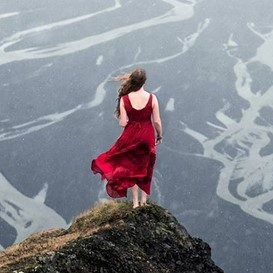

In [9]:
# input image
input_image = load_img("subject_img.jpg")
input_image1 = load_img("subject_img1.jpg")

show_img("subject_img.jpg")

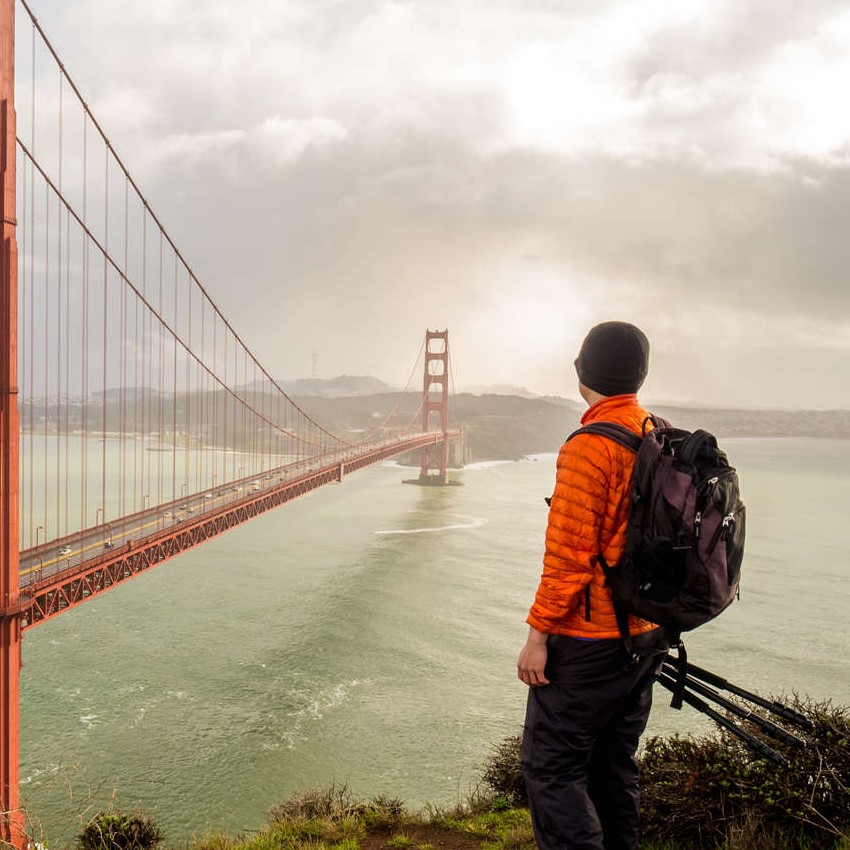

In [10]:
show_img("subject_img1.jpg")

In [0]:
# choosing a hidden convolutional layer from the inception model
layer_tensor = model.layer_tensors[6]

In [12]:
result = optimize_image(layer_tensor, input_image, epochs=30, learning_rate=7.0)
result1 = optimize_image(layer_tensor, input_image1, epochs=30, learning_rate=7.0)

 >> Iteration  0  complete!
 >> Iteration  5  complete!
 >> Iteration  10  complete!
 >> Iteration  15  complete!
 >> Iteration  20  complete!
 >> Iteration  25  complete!
 >> Training complete!
 >> Iteration  0  complete!
 >> Iteration  5  complete!
 >> Iteration  10  complete!
 >> Iteration  15  complete!
 >> Iteration  20  complete!
 >> Iteration  25  complete!
 >> Training complete!


In [0]:
# saving result image to disk
save_img(result, "result.jpg")
save_img(result1, "result1.jpg")

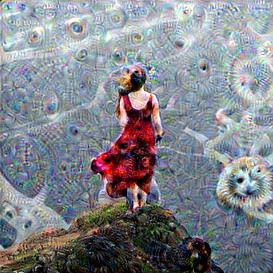

In [14]:
show_img("result.jpg")

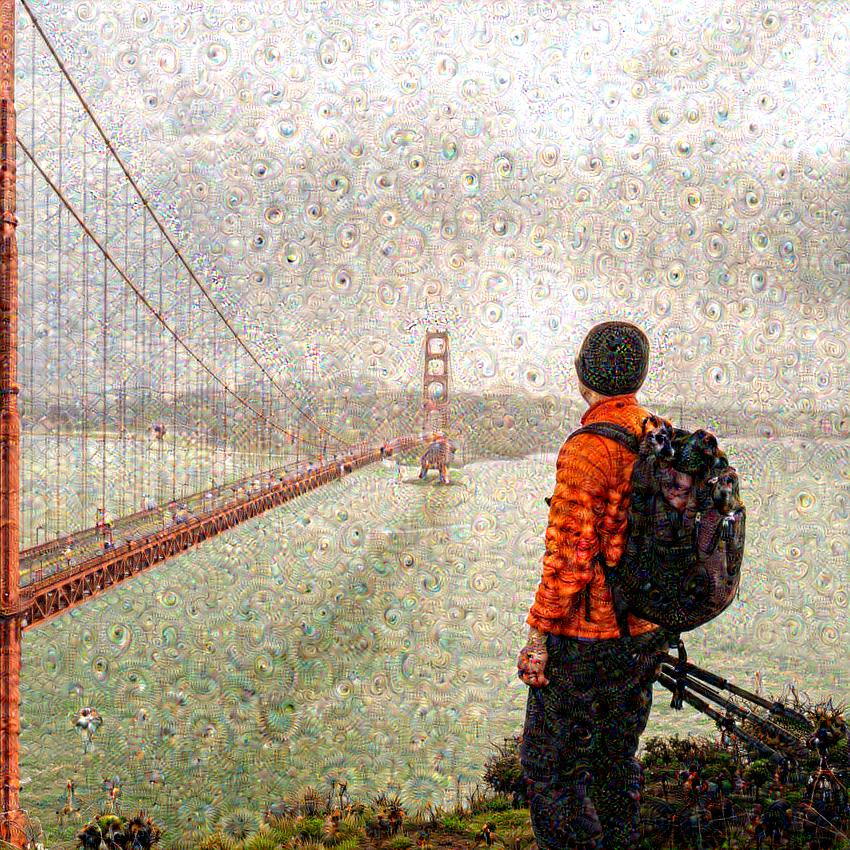

In [15]:
show_img("result1.jpg")

##<center> Inspired By
<center>https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/14_DeepDream.ipynb<center>